Процесс очистки данных см. в `./other/Attempt 2 (Touhou)/CleanDataset.ipynb` </br>
Оригинальный файл: `./other/Attempt 2 (Touhou)/Train.ipynb`

# Обучение нейронной сети для классификации изображений, используя свой датасет

In [1]:
# импортируем бэкенд Agg из matplotlib для сохранения графиков на диск
import matplotlib
matplotlib.use("Agg")

In [20]:
# Подключаем необходимые модули и пакеты
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from tensorflow.keras.optimizers import SGD
from tqdm.keras import TqdmCallback
import plotly.graph_objects as go
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5067635510477135677,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5717884928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16876693669516918544
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6"]

In [3]:
# инициализируем данные и метки
print("[INFO] loading images...")
data = []
labels = []

[INFO] loading images...


In [4]:
path = './mapped_dataset'
# Собираем список путей к каждому изображению и перемешиваем их
filtered_image_paths = filter(lambda x: 
                              'flandre_scarlet' in x or 
                              'konpaku_youmu' in x or
                              'komeiji_koishi' in x, paths.list_images(path))

imagePaths = sorted(list(filtered_image_paths))
random.shuffle(imagePaths)

In [5]:
from tqdm import tqdm

data = []
labels = []

for imagePath in tqdm(imagePaths, total=len(imagePaths)):

	image = cv2.imread(imagePath) # загружаем изображение
	image = cv2.resize(image, (64, 64)).flatten() # меняем его разрешение на 64x64 пикселей (без учета соотношения сторон),
																								# сглаживаем его в 64x64x3=12 288 пикселей
	data.append(image) # добавляем в список

	label = imagePath.split(os.path.sep)[-2] 	# извлекаем метку класса из пути к изображению (метка класса зависит от имени папки)
	labels.append(label) # обновляем список меток

100%|██████████| 3722/3722 [04:08<00:00, 14.98it/s]


Нормализация данных

In [12]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

Разбиваем данные на обучающую и тестовую выборки, используя 75%. Данных для обучения и оставшиеся 25% для тестирования

In [13]:
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

Конвертируем метки из целых чисел в векторы (для 2х классов при бинарной классификации вам следует использовать функцию Keras "to_categorical" вместо "LabelBinarizer" из scikit-learn, которая не возвращает вектор).

In [14]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

Определим архитектуру нейронной сети

In [23]:
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu")) 
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

Инициализируем скорость обучения и общее количество эпох

In [22]:
INIT_LR = 0.01
EPOCHS = 50
BATCH_SIZE = 200

Компилируем модель, используя SGD как оптимизатор и категориальную кросс-энтропию в качестве функции потерь (для бинарной классификации следует использовать binary_crossentropy)

In [24]:
from tensorflow.keras.optimizers import SGD

print("[INFO] training network...")
opt = SGD(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] training network...


In [25]:
# обучаем нейросеть
H = model.fit(trainX, trainY, validation_data=(testX, testY),
		epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [26]:
fig = go.Figure()

for key, _ in H.history.items():
	fig.add_trace(go.Scattergl(y=H.history[key],
		     name=key))
        
fig.update_layout(height=500, width=700,
	   xaxis_title='Epoch',
	   yaxis_title='Loss')
	
fig.update_xaxes(range=[0, EPOCHS])
fig.update_yaxes(range=[0, 2])

fig.show()

Сохраняем модель и метки классов в бинарном представлении на диск

In [27]:
print("[INFO] serializing network and label binarizer...")
model.save("h3model.h5", save_format="h5")
f = open("label_bin", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network and label binarizer...


# Проверка обученной модели пользовательскими данными

In [39]:
from keras.models import load_model
from keras import models    
from IPython.display import Image
import matplotlib.pyplot as plt
import argparse
import pickle
import cv2

import ipyplot

In [33]:
# загружаем модель и бинаризатор меток
print("[INFO] loading network and label binarizer...")
model = models.load_model("h3model.h5")
lb = pickle.loads(open("label_bin", "rb").read())

[INFO] loading network and label binarizer...


# Ручная проверка

Загружаем входное изображение, меняем его размер на необходимый. "Выравниваем" изображение (преобразуем его в вектор. Из 32х32х3 -> 3072). Масштабируем значения пикселей к диапазону [0, 1]

In [61]:
image = cv2.imread('./tests/flandre_scarlet/2.jpg')
output = image.copy()

image = cv2.resize(image, (64, 64))
# "Выравниваем" изображение (преобразуем его в вектор. Из 32х32х3 -> 3072)
image = image.flatten()
# масштабируем значения пикселей к диапазону [0, 1]
image = image.astype("float") / 255.0
image = image.reshape((1, image.shape[0]))

Делаем предсказание на изображении

In [62]:
preds = model.predict(image)
print(preds)

[[0.79930824 0.16258281 0.03810896]]


Находим индекс метки класса с наибольшей вероятностью соответствия

In [63]:
i = preds.argmax(axis=1)[0]
label = lb.classes_[i]

Показать изображение


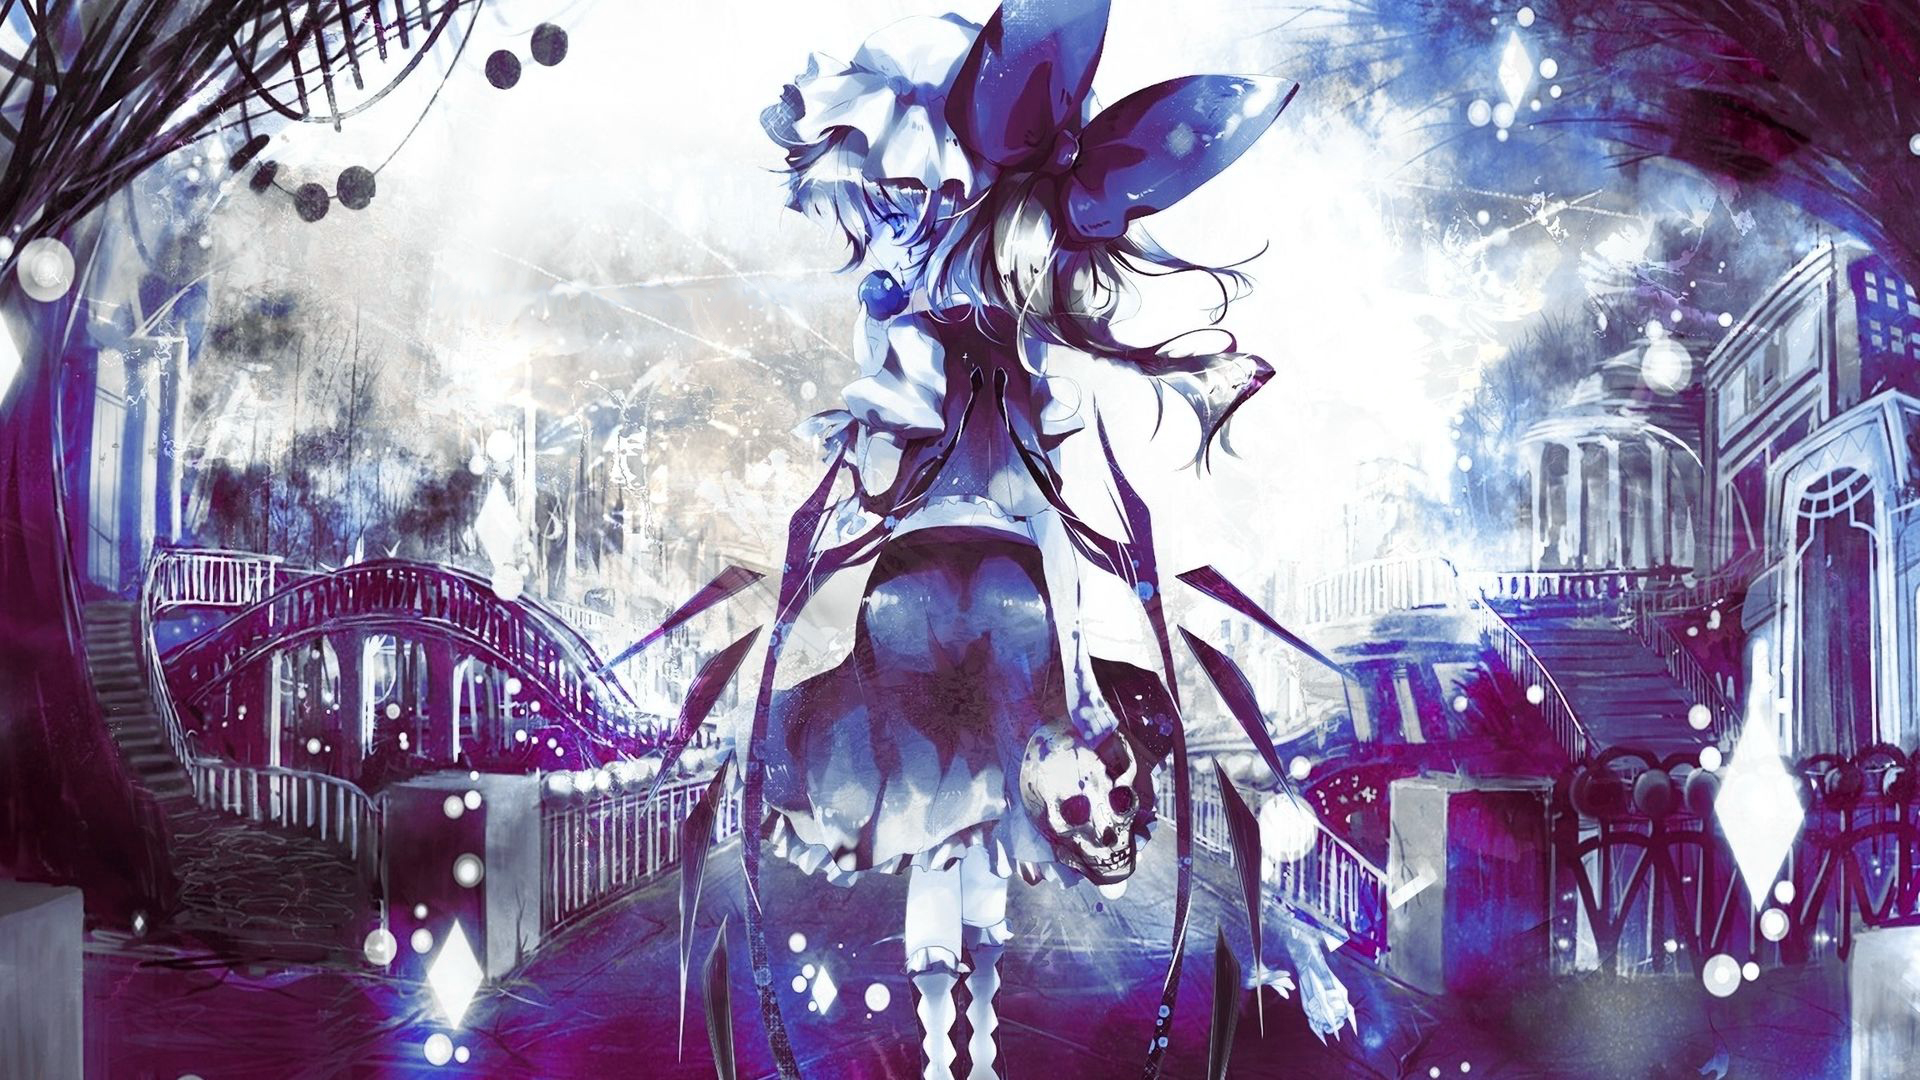


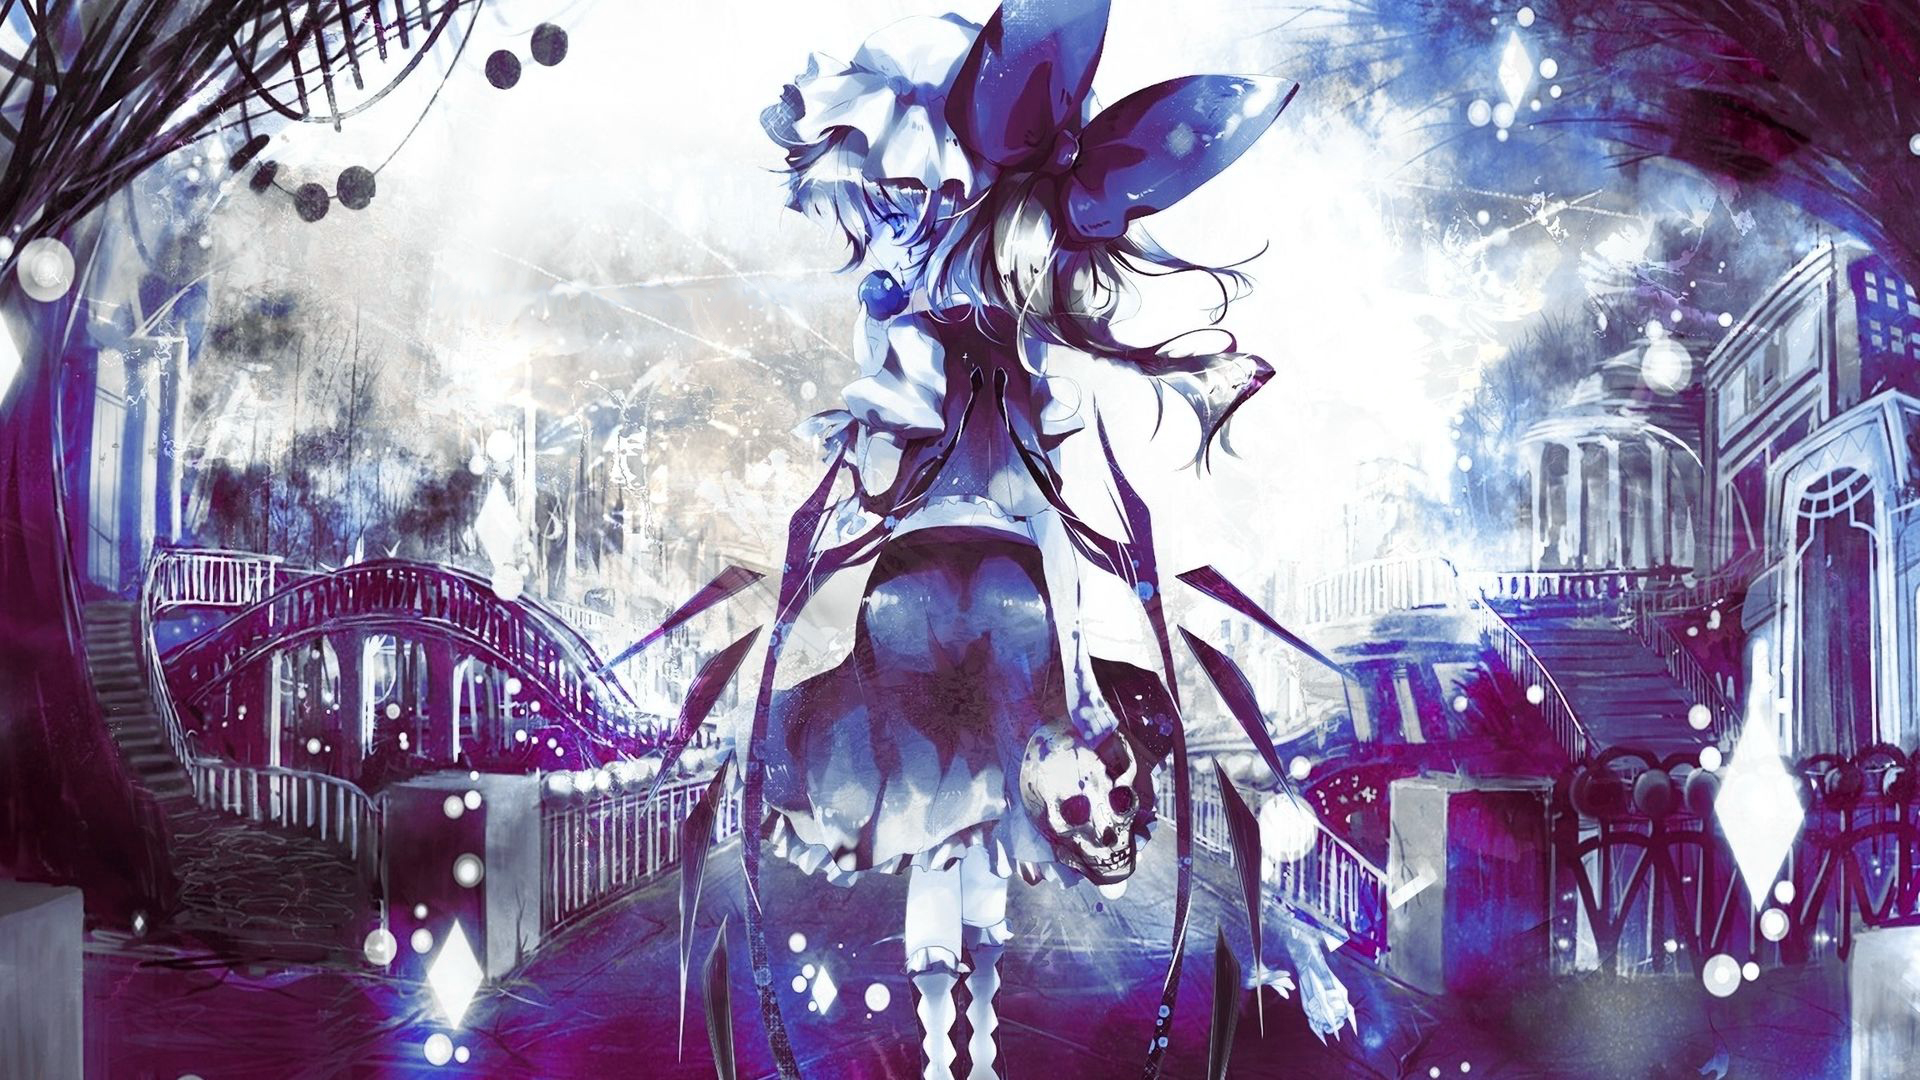

In [65]:
ipyplot.plot_images([output], [label], max_images=1, img_width=200)

# Автоматическое тестирование

In [34]:
def predict_image(imagepath, model, labels):
    image = cv2.imread(imagepath)
    output = image.copy()

    image = cv2.resize(image, (64, 64))
    # "Выравниваем" изображение (преобразуем его в вектор. Из 32х32х3 -> 3072)
    image = image.flatten()
    # масштабируем значения пикселей к диапазону [0, 1]
    image = image.astype("float") / 255.0
    image = image.reshape((1, image.shape[0]))

    # делаем предсказание на изображении
    preds = model.predict(image)

    predsList = preds.tolist()[0]
    for i in range(len(predsList)):
        print(f'{labels.classes_[i]:20} - {predsList[i]}')

    # находим индекс метки класса с наибольшей вероятностью
    # соответствия
    i = preds.argmax(axis=1)[0]
    label = labels.classes_[i]

    
    # Добавляем на исходное изображение метку класса и вероятность прогноза
    text = "{}: {:.2f}%".format(label, preds[0][i] * 100)
    cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
    	(0, 0, 255), 2)
    
    cv2.imwrite('output.jpg', output)

In [35]:
def predict(imagepath, model):
    image = cv2.imread(imagepath)
    image = cv2.resize(image, (64, 64))
    image = image.flatten()
    image = image.astype("float") / 255.0
    image = image.reshape((1, image.shape[0]))

    return model.predict(image)

In [36]:
test_data = {
    'flandre_scarlet': [
        './tests/flandre_scarlet/1.jpg',
        './tests/flandre_scarlet/2.jpg',
        './tests/flandre_scarlet/3.jpg',
        './tests/flandre_scarlet/4.jpg',
        './tests/flandre_scarlet/5.jpg'
    ],

    'konpaku_youmu': [
        './tests/konpaku_youmu/1.jpg',
        './tests/konpaku_youmu/2.jpg',
        './tests/konpaku_youmu/3.jpg',
        './tests/konpaku_youmu/4.jpg',
        './tests/konpaku_youmu/5.jpg'
    ],

    'komeiji_koishi': [
        './tests/komeiji_koishi/1.jpg',
        './tests/komeiji_koishi/2.jpg',
        './tests/komeiji_koishi/3.jpg',
        './tests/komeiji_koishi/4.jpg',
        './tests/komeiji_koishi/5.jpg'
    ]
}

In [37]:
lb.classes_

array(['flandre_scarlet', 'komeiji_koishi', 'konpaku_youmu'], dtype='<U15')

In [57]:
def test(label):
    image_array = []
    predictions_list = []
    test_images = test_data[label]

    for image in test_images:
        prediction = predict(image, model)

        i = prediction.argmax(axis=1)[0]
        predicted_label = lb.classes_[i]

        prediction_text = ''
        
        if predicted_label != label:
            prediction_text = f'❌ - {predicted_label:20}\n{prediction[0][i]}'
        else:
            prediction_text = f'✔️ - {label:20}\n{prediction[0][i]}'

        image_array.append(image)
        predictions_list.append(prediction_text)

    ipyplot.plot_images(image_array,predictions_list, max_images=len(test_images), img_width=200)

In [58]:
test('flandre_scarlet')

In [59]:
test('konpaku_youmu')

In [60]:
test('komeiji_koishi')